# UTS - Logistic Regression

## Mengimpor library yang akan digunakan

In [1]:
# For Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# For Data Manipulation
import numpy as np 
import pandas as pd
import sklearn
from itertools import cycle


# For Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For Classification Results
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.exceptions import NotFittedError

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Importing Models
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.neighbors import KNeighborsClassifier as KNN #K-Nearest Neighbors
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree Classifier
from sklearn.model_selection import GridSearchCV

## Memasukkan dataset yang ingin digunakan

In [2]:
df = pd.read_csv('winequality-red.csv', 
                   sep = ';', 
                   engine = 'python')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Mempersiapkan dataset

5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: quality, dtype: float64


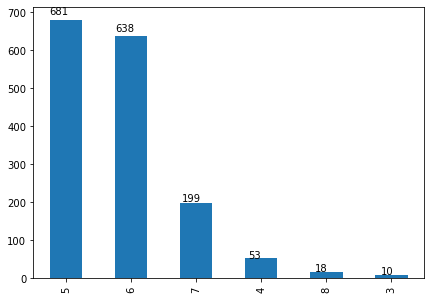

In [3]:
ax = df["quality"].value_counts().plot.bar(figsize=(7,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
plt.style.use('grayscale')
print(df["quality"].value_counts(normalize=True)*100)

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
df["is good"] = 0
df.loc[df["quality"]>=7,"is good"] = 1
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 0.5), color="white")
    
print(df["is good"].value_counts(normalize=True)*100)

0    86.429018
1    13.570982
Name: is good, dtype: float64


In [7]:
features = df.columns[:-2]
output = df.columns[-1]
print("Features: \n{}, \n\nLabels: \n{}".format(features.values,output))

Features: 
['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol'], 

Labels: 
is good


In [8]:
X = df[features].values
y = df[output].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.50)
print('Training size: {}, Testing size: {}'.format(X_train.size,X_test.size))

Training size: 8789, Testing size: 8800


In [10]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [11]:
def get_probabilty_output(X_test, model_fitted, value_count=10):
    def highlight_max(data, color='grayscale'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = data == data.max().max()
            return pd.DataFrame(np.where(is_max, attr, ''), index=data.index, columns=data.columns)
        
    y_scores = model_fitted.predict_proba(X_test)
    prob_df = pd.DataFrame(y_scores*100).head(value_count)
    styled_df = prob_df.style.background_gradient(cmap='Greys_r')
    styled_df = styled_df.highlight_max(axis=1, color='grayscale')
    return styled_df

In [12]:
def get_classification_report(y_test,predictions,average="macro"):
    #Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, cmap="gray")
    plt.title("Confusion Matrix")
    plt.style.use('grayscale')
    
    acc = accuracy_score(y_test, predictions)
    pre = precision_score(y_test, predictions, average=average)
    rec = recall_score(y_test, predictions, average=average)
    # Prediction Report
    print(classification_report(y_test, predictions, digits=3))
    print("Overall Accuracy:", acc)
    print("Overall Precision:", pre)
    print("Overall Recall:", rec)
    
    return acc,pre,rec

In [13]:
def get_classification_ROC(X,y,model,test_size,model_fitted=False,random_state=0):
    
    def check_fitted(clf): 
        return hasattr(clf, "classes_")
    
    if(len(np.unique(y)) == 2):
        #Binary Classifier
        if not check_fitted(model):
            model = model.fit(X,y)
        
        plot_roc_curve(model, X, y)
        y_score = model.predict_proba(X)[:, 1]
        fpr, tpr, threshold = roc_curve(y, y_score)
        auc = roc_auc_score(y, y_score)
        return auc
#         print("False Positive Rate: {} \nTrue Positive Rate: {} \nThreshold:{}".format(fpr,tpr,threshold))
    
    else:
        #Multiclass Classifier
        y_bin = label_binarize(y, classes=np.unique(y))
        n_classes = y_bin.shape[1]

        # shuffle and split training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=test_size, random_state=random_state)

        # Learn to predict each class against the other
        classifier = OneVsRestClassifier(model)
        model_fitted = classifier.fit(X_train, y_train)
        try:
            y_score = model_fitted.decision_function(X_test)
        except:
            y_score = model_fitted.predict_proba(X_test)



        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])


        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


        plt.figure()
        lw = 2
        plt.plot(fpr[2], tpr[2], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic averaged')
        plt.legend(loc="lower right")
        plt.show()



        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(10,10))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'purple', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('multi-class ROC (One vs All)')
        plt.legend(loc="lower right")
        plt.style.use('grayscale')
        plt.show()

# Logistic Regression

## Hyperparameter

In [14]:
parameters_logreg = {
    "solver" : ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    "penalty" : ('l1', 'l2', 'elasticnet', 'none'),
    "C" : [0.01, 0.1, 1, 10, 1000]
    
}

## Parameter 1

### Memasukkan parameter kedalam data train

In [15]:
lr = LogisticRegression(C = 0.01, solver = 'liblinear', penalty = 'l1')
lr.fit(X_train,y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

### Memprediksi hasil tes yang dilakukan

In [16]:
yhat = lr.predict(X_test)
yhat_prob = lr.predict_proba(X_test)

### Mendapatkan hasil dan memunculkannya

In [17]:
get_probabilty_output(X_test=X_test, model_fitted=lr, value_count=15)

,0,1
0,73.238557,26.761443
1,75.252870,24.747130
2,73.612427,26.387573
3,68.911616,31.088384
4,72.480808,27.519192
5,76.134119,23.865881
6,73.238557,26.761443
7,73.238557,26.761443
8,75.784223,24.215777
9,73.050366,26.949634


### Mengkalkulasikan akurasi dari parameter beserta Confussion Matrix

              precision    recall  f1-score   support

           0      0.864     1.000     0.927       691
           1      0.000     0.000     0.000       109

    accuracy                          0.864       800
   macro avg      0.432     0.500     0.463       800
weighted avg      0.746     0.864     0.801       800

Overall Accuracy: 0.86375
Overall Precision: 0.431875
Overall Recall: 0.5


C:\Users\aurel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\anaconda3\lib\site-packages\sklearn\metrics\_classifi

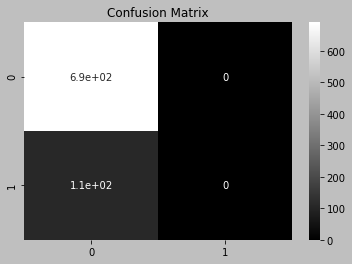

In [18]:
acc_LR,pre_LR,rec_LR = get_classification_report(y_test,yhat)

### Mengkalkulasikan nilai AUC pada parameter

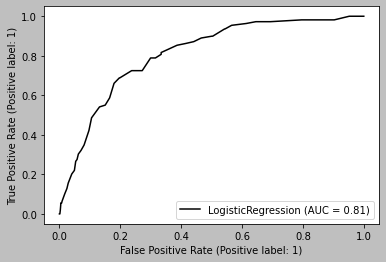

In [19]:
auc_LR = get_classification_ROC(X_test,y_test,lr,test_size=0.5,random_state=0)

## Parameter 2

### Memasukkan parameter kedalam data train, Memprediksi hasil tes yang dilakukan, Memunculkan hasil dalam bentuk tabel

In [20]:
lr2 = LogisticRegression(C = 1, solver = 'liblinear', penalty = 'l2')
lr2.fit(X_train,y_train)
yhat2 = lr2.predict(X_test)
yhat_prob = lr2.predict_proba(X_test)
get_probabilty_output(X_test=X_test, model_fitted=lr2, value_count=15)

,0,1
0,84.869408,15.130592
1,98.241470,1.758530
2,87.906622,12.093378
3,72.618069,27.381931
4,92.429270,7.570730
5,99.527315,0.472685
6,97.454349,2.545651
7,97.454349,2.545651
8,90.371984,9.628016
9,99.171290,0.828710


### Mengkalkulasikan akurasi dari parameter beserta Confussion Matrix

              precision    recall  f1-score   support

           0      0.898     0.957     0.926       691
           1      0.531     0.312     0.393       109

    accuracy                          0.869       800
   macro avg      0.715     0.634     0.660       800
weighted avg      0.848     0.869     0.854       800

Overall Accuracy: 0.86875
Overall Precision: 0.7146739130434783
Overall Recall: 0.6342556327088782


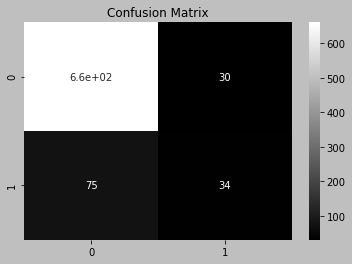

In [21]:
acc_LR2,pre_LR2,rec_LR2 = get_classification_report(y_test,yhat2)

### Mengkalkulasikan nilai AUC pada parameter

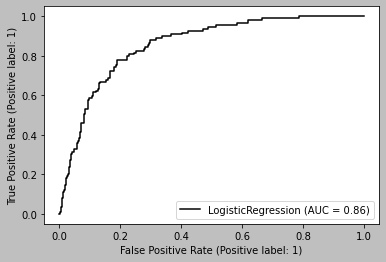

In [22]:
auc_LR2 = get_classification_ROC(X_test,y_test,lr2,test_size=0.5,random_state=0)

## Parameter 3

### Memasukkan parameter kedalam data train, Memprediksi hasil tes yang dilakukan, Memunculkan hasil dalam bentuk tabel

In [23]:
lr3 = LogisticRegression(C = 0.1, solver = 'newton-cg', penalty = 'l2')
lr3.fit(X_train,y_train)
yhat3 = lr3.predict(X_test)
yhat_prob = lr3.predict_proba(X_test)
get_probabilty_output(X_test=X_test, model_fitted=lr3, value_count=15)

,0,1
0,83.388996,16.611004
1,97.777778,2.222222
2,87.286296,12.713704
3,66.426318,33.573682
4,90.360650,9.639350
5,98.502374,1.497626
6,96.885588,3.114412
7,96.885588,3.114412
8,89.041712,10.958288
9,99.153476,0.846524


### Mengkalkulasikan akurasi dari parameter beserta Confussion Matrix

              precision    recall  f1-score   support

           0      0.892     0.970     0.929       691
           1      0.571     0.257     0.354       109

    accuracy                          0.873       800
   macro avg      0.732     0.613     0.642       800
weighted avg      0.848     0.873     0.851       800

Overall Accuracy: 0.8725
Overall Precision: 0.7317861898421152
Overall Recall: 0.6132449979420863


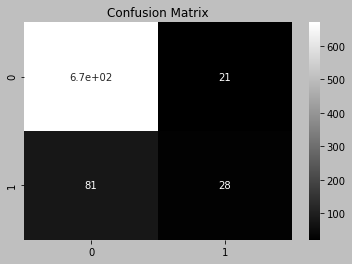

In [24]:
acc_LR3,pre_LR3,rec_LR3 = get_classification_report(y_test,yhat3)

### Mengkalkulasikan nilai AUC pada parameter

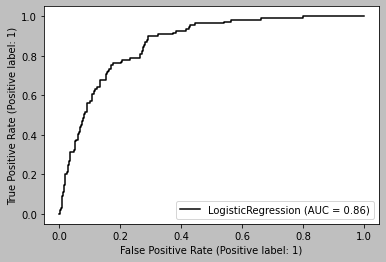

In [25]:
auc_LR3 = get_classification_ROC(X_test,y_test,lr3,test_size=0.5,random_state=0)

## Parameter 4

### Memasukkan parameter kedalam data train, Memprediksi hasil tes yang dilakukan, Memunculkan hasil dalam bentuk tabel

In [26]:
lr4 = LogisticRegression(C = 10, solver = 'newton-cg', penalty = 'l2')
lr4.fit(X_train,y_train)
yhat4 = lr4.predict(X_test)
yhat_prob = lr4.predict_proba(X_test)
get_probabilty_output(X_test=X_test, model_fitted=lr4, value_count=15)

,0,1
0,86.197460,13.802540
1,98.626456,1.373544
2,88.871889,11.128111
3,75.704341,24.295659
4,93.659599,6.340401
5,99.765434,0.234566
6,97.995018,2.004982
7,97.995018,2.004982
8,91.535219,8.464781
9,99.330651,0.669349


### Mengkalkulasikan akurasi dari parameter beserta Confussion Matrix

              precision    recall  f1-score   support

           0      0.898     0.954     0.925       691
           1      0.515     0.312     0.389       109

    accuracy                          0.866       800
   macro avg      0.706     0.633     0.657       800
weighted avg      0.846     0.866     0.852       800

Overall Accuracy: 0.86625
Overall Precision: 0.7064858393196267
Overall Recall: 0.6328084547059839


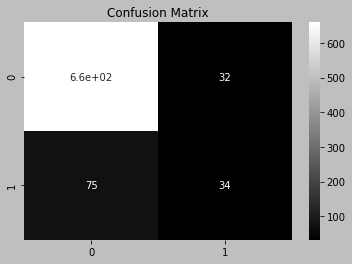

In [27]:
acc_LR4,pre_LR4,rec_LR4 = get_classification_report(y_test,yhat4)

### Mengkalkulasikan nilai AUC pada parameter

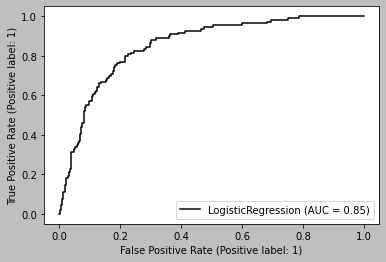

In [28]:
auc_LR4 = get_classification_ROC(X_test,y_test,lr4,test_size=0.5,random_state=0)

## TABEL DAN GRAFIK

### Membuat dataframe/tabel baru yang berisikan setiap informasi tentang hasil akurasi yang dihasilkan oleh tiap parameter

In [29]:
result = pd.DataFrame(
    [["Parameter1",auc_LR*100,acc_LR*100,pre_LR*100,rec_LR*100],
    ["Parameter2",auc_LR2*100,acc_LR2*100,pre_LR2*100,rec_LR2*100],
    ["Parameter3",auc_LR3*100,acc_LR3*100,pre_LR3*100,rec_LR3*100],
    ["Parameter4",auc_LR4*100,acc_LR4*100,pre_LR4*100,rec_LR4*100]],
    columns=["Parameter","AUC","Accuracy","Precision","Recall"]
)

result

,Parameter,AUC,Accuracy,Precision,Recall
0,Parameter1,80.984878,86.375,43.187500,50.000000
1,Parameter2,85.653022,86.875,71.467391,63.425563
2,Parameter3,86.389888,87.250,73.178619,61.324500
3,Parameter4,85.386158,86.625,70.648584,63.280845


### Membandingkan hasil prediksi dari tiap parameter dengan hasil yang sebenarnya (hasil tes)

In [30]:
dataset = {'Actual': y_test,'Prediction 1': yhat,'Prediction 2': yhat2,'Prediction 3': yhat3,'Prediction 4': yhat4}
df = pd.DataFrame(dataset)
df.head()

,Actual,Prediction 1,Prediction 2,Prediction 3,Prediction 4
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,0


### Mengimpor data kedalam excel

In [31]:
df.to_excel("LR.xlsx",sheet_name='Logistic Regression')

### Membuat grafik komparasi nilai UAC tiap Parameter

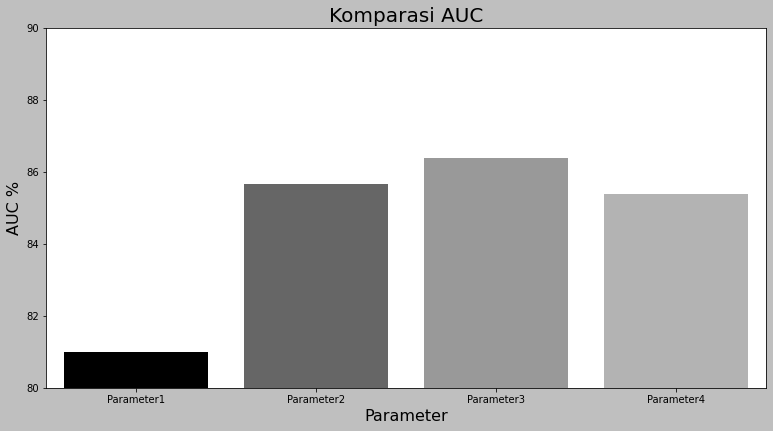

In [32]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = result.Parameter
y = result.AUC
sns.barplot(x=x, y=y)
plt.ylim(ymin=80)
plt.ylim(ymax=90)
plt.title("Komparasi AUC", fontsize = 20)
plt.ylabel('AUC %', fontsize = 16)
plt.xlabel('Parameter', fontsize = 16)
plt.style.use('grayscale')
plt.show()

### Membuat grafik komparasi Akurasi tiap Parameter

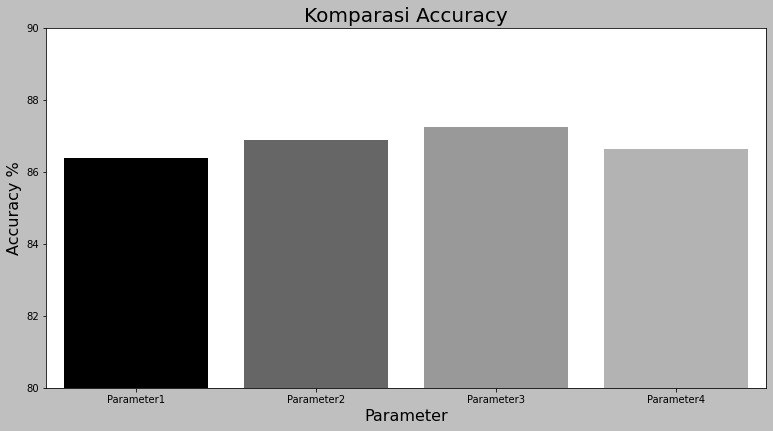

In [33]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = result.Parameter
y = result.Accuracy
sns.barplot(x=x, y=y)
plt.ylim(ymin=80)
plt.ylim(ymax=90)
plt.title("Komparasi Accuracy", fontsize = 20)
plt.ylabel('Accuracy %', fontsize = 16)
plt.xlabel('Parameter', fontsize = 16)
plt.style.use('grayscale')
plt.show()

### Membuat grafik komparasi Presisi tiap Parameter

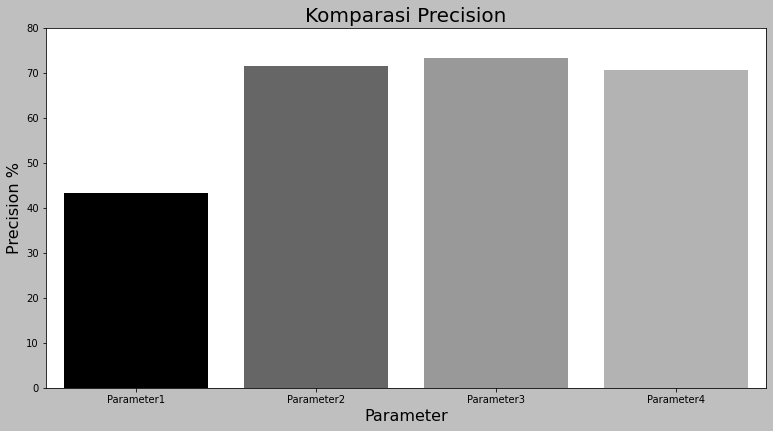

In [34]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = result.Parameter
y = result.Precision
sns.barplot(x=x, y=y)
plt.ylim(ymin=0)
plt.ylim(ymax=80)
plt.title("Komparasi Precision", fontsize = 20)
plt.ylabel('Precision %', fontsize = 16)
plt.xlabel('Parameter', fontsize = 16)
plt.style.use('grayscale')
plt.show()

### Membuat grafik komparasi Recall tiap Parameter

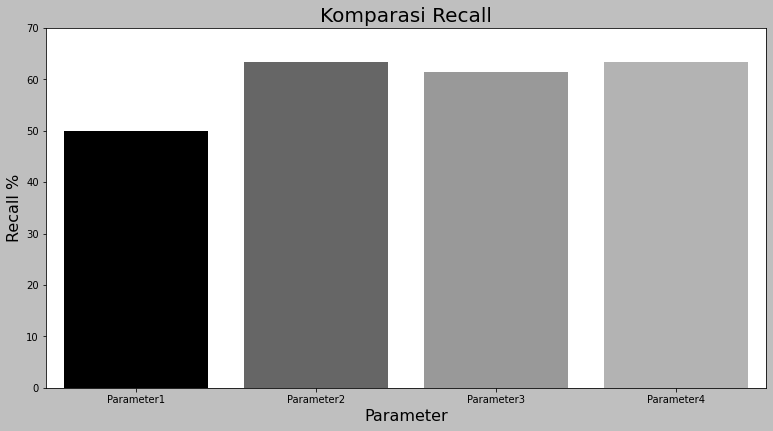

In [35]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
x = result.Parameter
y = result.Recall
sns.barplot(x=x, y=y)
plt.ylim(ymin=0)
plt.ylim(ymax=70)
plt.title("Komparasi Recall", fontsize = 20)
plt.ylabel('Recall %', fontsize = 16)
plt.xlabel('Parameter', fontsize = 16)
plt.style.use('grayscale')
plt.show()